In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import h5py ,os
import datetime
from scipy import stats
from math import sqrt
from scipy import optimize
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

In [2]:
#load data
path = "C:/Users/Administrator/Documents/"
dirs = os.listdir(path)
data = {}
for x in dirs:
    if os.path.splitext(x)[1]=='.npy':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = np.load(file)
        data[name]=value
indices = h5py.File('C:/Users/Administrator/Documents/members.hdf5','r')

In [3]:
#to data frame
dates = pd.to_datetime(data['dates'])
tick = data['ticker_names']
pd_Volume = pd.DataFrame(data['Volume'].T,index=dates,columns=tick)
pd_industry_2 = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'].T,index=dates,columns=tick)
pd_VWAP = pd.DataFrame(data['VWAP'].T,index=dates,columns=tick)
pd_ClosePrice = pd.DataFrame(data['ClosePrice'].T,index=dates,columns=tick)
pd_marketcap = pd.DataFrame(data['CAPQ0_FLOAT_A_SHR'].T,index=dates,columns=tick)
adj_f = pd.DataFrame(data['AdjFactor'].T,index=dates,columns=tick)
                                  
fd_dates = pd.to_datetime(data['EPS_dates'])
fd_tick = data['EPS_ticker_names']
pd_eps = pd.DataFrame(data['EPS_BASIC'].T,index = fd_dates,columns=fd_tick)
pd_bps = pd.DataFrame(data['BPS'].T,index = fd_dates,columns=fd_tick)
pd_eps = pd_eps.loc[dates,tick]
pd_bps = pd_bps.loc[dates,tick]
pd_ep = pd_eps/pd_ClosePrice*adj_f
pd_bp = pd_bps/pd_ClosePrice*adj_f
pd_return = np.log(pd_ClosePrice/pd_ClosePrice.shift(1))
days = pd.DataFrame(data['dates'],index=dates).resample('M').last()

In [4]:
pd_return_fama = pd_return.resample('M').sum()
pd_marketcap_fama = pd_marketcap.resample('M').first()
pd_bp_fama = pd_bp.resample('M').first()
pd_industry_fama = pd_industry_2.resample('M').first()


In [24]:
dateindex = pd.DataFrame(data['dates'],index=dates)
dateindex_m = dateindex.resample('M').first()

In [128]:
smb = []
hml = []
ob_t = pd_return_fama.index[-150:-10]

def mc_weighted(marketcap,returns):
    return(marketcap/marketcap.sum()*returns)

for i in ob_t:
    selected = np.append(indices['000905'][days.loc[i,0]][:].astype('U6'),indices['000300'][days.loc[i,0]][:].astype('U6'))
    
    hml_sort = np.argsort(pd_bp_fama.loc[i,selected])
    l = hml_sort[:int(len(selected)/10*3)].index
    h = hml_sort[::-1][:int(len(selected)/10*3)].index
    m = hml_sort[int(len(selected)/10*3):int(len(selected)/10*7)].index
    smb_sort = np.argsort(pd_marketcap_fama.loc[i,selected])
    b = smb_sort[::-1][:int(len(selected)/2)].index
    s = smb_sort[:int(len(selected)/2)].index
    
    bl = mc_weighted(pd_marketcap_fama.loc[i,b.union(l)],pd_return_fama.loc[i,b.union(l)]).sum()
    bh = mc_weighted(pd_marketcap_fama.loc[i,b.union(h)],pd_return_fama.loc[i,b.union(h)]).sum()
    bm = mc_weighted(pd_marketcap_fama.loc[i,b.union(m)],pd_return_fama.loc[i,b.union(m)]).sum()
    sl = mc_weighted(pd_marketcap_fama.loc[i,s.union(l)],pd_return_fama.loc[i,s.union(l)]).sum()
    sh = mc_weighted(pd_marketcap_fama.loc[i,s.union(h)],pd_return_fama.loc[i,s.union(h)]).sum()
    sm = mc_weighted(pd_marketcap_fama.loc[i,s.union(m)],pd_return_fama.loc[i,s.union(m)]).sum()
    
    smb.append((sl+sh+sm-bl-bh-bm)/3)
    hml.append((sh+bh-sl-bl)/2)
    
smb = pd.Series(smb,index=ob_t)
hml = pd.Series(hml,index=ob_t)

In [169]:
index_Closeprice = pd.DataFrame(data['index_ClosePrice'],index=data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T.loc[:,['000905','000300']]
index_return = np.log(index_Closeprice/index_Closeprice.shift(1))
index_return_fama = index_return.resample('M').sum()
index_return_fama

,000905,000300
1990-12-31,0.000000,0.000000
1991-01-31,0.000000,0.000000
1991-02-28,0.000000,0.000000
1991-03-31,0.000000,0.000000
1991-04-30,0.000000,0.000000
...,...,...
2020-12-31,0.007278,0.049371
2021-01-31,-0.003300,0.026637
2021-02-28,0.002866,-0.002845
2021-03-31,-0.017480,-0.055555


In [248]:
selected=indices['000300'][days.loc[ob_t[0],0]][:].astype('U6')
fama_beta = np.empty([4,len(ob_t)-24,300], dtype = float)
fama_t = fama_beta.copy()
fama_rs = pd.DataFrame(None,index=ob_t[24:],columns=selected)
for k in range(len(ob_t)-24):
    for j in range(len(selected)):    
        i = ob_t[k:k+24]
        X = pd.concat([pd.Series(1,index=i),index_return_fama.loc[i,'000300'],smb.loc[i],hml.loc[i]],axis = 1)
        X = np.mat(X)
        y = np.mat(pd_return_fama.loc[i,selected[j]]).T
        beta = (X.T*X).I*X.T*y
        u = y-X*beta

        varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
        se = np.sqrt(np.array(np.diag(varbeta)))
        fama_beta[:,k,j] = beta.T
        fama_t[:,k,j] = (beta.T/se.T)
        fama_rs.iloc[k,j] = (1-((np.array(u.T)[0]**2).sum()/(np.array(y.T)[0]**2).sum()))
fama_rs

<ipython-input-248-c893c577338a>:17: RuntimeWarning: invalid value encountered in true_divide
  fama_t[:,k,j] = (beta.T/se.T)
<ipython-input-248-c893c577338a>:18: RuntimeWarning: invalid value encountered in double_scalars
  fama_rs.iloc[k,j] = (1-((np.array(u.T)[0]**2).sum()/(np.array(y.T)[0]**2).sum()))


,601601,600016,601857,002202,600050,600900,600690,000538,000876,601088,...,600153,000423,600100,000630,600170,600188,600221,600583,600089,000709
2008-11-30,0.828393,0.838316,0.736995,0.537585,0.647277,0.53783,0.420467,0.351442,0.315125,0.858295,...,0.614857,0.418514,0.373368,0.8365,0.72484,0.779052,0.683,0.794622,0.535724,0.781508
2008-12-31,0.858542,0.859483,0.717445,0.507463,0.661295,0.560234,0.384875,0.262521,0.306923,0.887842,...,0.601233,0.416025,0.34244,0.822997,0.71632,0.791952,0.580579,0.785478,0.499983,0.793241
2009-01-31,0.851657,0.860929,0.741107,0.525239,0.657777,0.573206,0.387023,0.214182,0.311804,0.894762,...,0.702382,0.452113,0.330002,0.745112,0.723793,0.792351,0.576512,0.76361,0.506733,0.82336
2009-02-28,0.844984,0.851662,0.747625,0.511958,0.662846,0.58152,0.416555,0.243964,0.283336,0.883981,...,0.70599,0.435066,0.277585,0.687555,0.683601,0.757545,0.548693,0.71118,0.537303,0.81008
2009-03-31,0.851045,0.851699,0.744407,0.503547,0.663347,0.582044,0.449203,0.218469,0.278535,0.896571,...,0.732823,0.386788,0.350029,0.681531,0.684426,0.776822,0.531874,0.722832,0.544365,0.829072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-28,0.578009,0.730619,0.498236,0.52315,0.567502,0.0490683,0.462971,0.37054,0.235764,0.758495,...,0.728413,0.56741,0.670371,0.761103,0.517172,0.562103,0.510643,0.34239,0.651048,0.496902
2018-03-31,0.708371,0.717699,0.449819,0.520912,0.542645,0.0763242,0.4578,0.350743,0.256876,0.76089,...,0.770488,0.545092,0.667942,0.734271,0.516445,0.528604,0.494252,0.295573,0.629015,0.56766
2018-04-30,0.707622,0.632211,0.506115,0.546831,0.540336,0.0575924,0.483388,0.315994,0.294054,0.601106,...,0.673627,0.619199,0.669697,0.7334,0.531881,0.476071,0.495428,0.346772,0.309063,0.53834
2018-05-31,0.720993,0.634039,0.497612,0.546742,0.523496,0.0583826,0.493267,0.319615,0.294813,0.581218,...,0.683949,0.587671,0.654347,0.685682,0.524168,0.484998,0.500592,0.333408,0.290075,0.478205


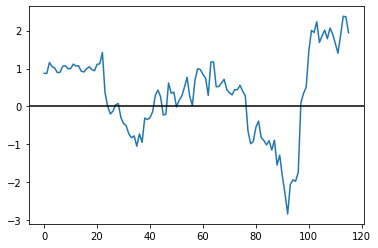

In [261]:
plt.plot(fama_t[0,:,8])
plt.axhline(y=0,c="black")

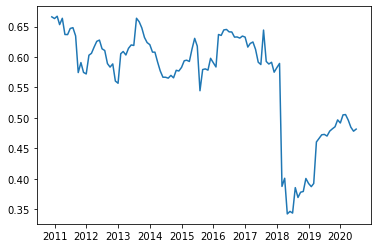

In [278]:
plt.plot(fama_rs.mean(axis=1))

In [271]:
np.nanmean(abs(fama_t[0,:,:]))

0.8398432232521996

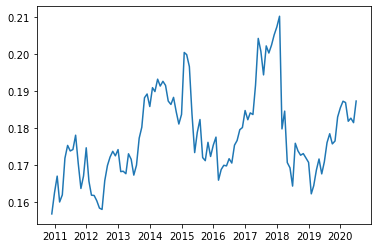

In [279]:
plt.plot(fama_rs.std(axis=1))


In [276]:
fama_rs.index = ob_t[24:]

In [297]:
k = pd.Series(map(datetime.datetime.weekday,dates),index=dates)

In [309]:
weekday_effect

,000905,0
2005-01-04,-0.013159,1.0
2005-01-05,0.016786,2.0
2005-01-06,-0.009046,3.0
2005-01-07,0.003023,4.0
2005-01-10,0.008714,0.0
...,...,...
2021-03-29,0.000503,0.0
2021-03-30,0.004055,1.0
2021-03-31,-0.004195,2.0
2021-04-01,0.009167,3.0


In [317]:
weekday_effect = pd.concat([index_return,k],axis=1).dropna(axis=0)

In [324]:
weekday_tvalue_500 = weekday_effect['000905'].groupby(weekday_effect[0]).mean()/weekday_effect['000905'].groupby(weekday_effect[0]).std()*np.sqrt(weekday_effect['000905'].groupby(weekday_effect[0]).count())

In [325]:
weekday_tvalue_300 = weekday_effect['000300'].groupby(weekday_effect[0]).mean()/weekday_effect['000300'].groupby(weekday_effect[0]).std()*np.sqrt(weekday_effect['000300'].groupby(weekday_effect[0]).count())

In [326]:
weekday_tvalue_300

0
0.0    2.099813
1.0    0.084533
2.0    1.302664
3.0   -2.090555
4.0    1.719621
Name: 000300, dtype: float64

In [330]:
weekday_effect['000300'].resample('Y').mean()

2005-12-31   -0.000329
2006-12-31    0.003291
2007-12-31    0.003973
2008-12-31   -0.004379
2009-12-31    0.002773
2010-12-31   -0.000552
2011-12-31   -0.001180
2012-12-31    0.000300
2013-12-31   -0.000334
2014-12-31    0.001700
2015-12-31    0.000223
2016-12-31   -0.000491
2017-12-31    0.000807
2018-12-31   -0.001201
2019-12-31    0.001262
2020-12-31    0.000990
2021-12-31   -0.000160
Freq: A-DEC, Name: 000300, dtype: float64

In [42]:
#obt is the date index need to be tested, it should be fully included in the axis 1
#data is 3-dimentional array, its index is axis
#axis is the list of indcies. axis0 should include all factors(size,industry,return...),axis1 should be timeline, axis2 should be ticknames
#indcies is alternative. It could be index code then only stocks in index will be included

def beta_test(mydata,axis,obt,indcies = None,choice = None,dateindex = None):

    axis0 = axis[0]
    axis1 = axis[1]
    axis2 = axis[2]

    #create empty dataframe
    beta_return = pd.DataFrame(None,index=ob_t,columns=axis0)
    t_values = beta_return.copy()

    #loop
    for i in ob_t:
        #get panel data 
        panel_data = pd.DataFrame(mydata[:,np.where(axis1 == i)[0][0],:],
                     index = axis0,columns=tick).T

        if indcies!= None:
            selected = indices[choice][dateindex.loc[i,0]].astype('U6')
            panel_data = panel_data.loc[selected,:]
        
        re = panel_data.loc[:,'return']
        #get dummies and drop others
        panel_data = pd.concat([panel_data,pd.get_dummies(panel_data['industry'])],axis=1)
        panel_data.drop(['industry','return'],axis=1,inplace = True)

        selected = panel_data.index

        #get beta ,u,and t-value through WLS 
        X = panel_data.copy()
        co = X.columns
        X = np.mat(X.to_numpy())
        y = np.mat(re[selected].to_numpy()).T
        w = np.mat(np.diag(1/np.sqrt(mv[selected])))
        beta = (X.T*w*X).I*X.T*w*y
        u = y-X*beta

        #estimated variation of regression
        varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
        se = np.sqrt(np.diag(varbeta))
        beta = pd.DataFrame(beta.T,columns=co)

        #record estimation
        t_values.loc[i,j]=(beta/se).loc[:,j].values[0]
        beta_return.loc[i,j]=beta.loc[:,j].values[0]

        print(i)
    return([t_values,beta_return])

In [35]:
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)

In [185]:
mydata = np.stack([pd_return_fama,pd_industry_fama,pd_marketcap_fama,pd_bp_fama])
axis0 = ['return','industry','marketcap','bp']
axis1 = dateinedx_m.index
axis2 = tick
ob_t = axis1[-100:-4]

#create empty dataframe
beta_return = pd.DataFrame(None,index=ob_t,columns=axis0)
t_values = beta_return.copy()

#loop
for i in ob_t:
    #get panel data 
    panel_data = pd.DataFrame(mydata[:,np.where(axis1 == i)[0][0],:],
                 index = axis0,columns=tick).T
    
    #index pool
    selected = indices['000905'][dateindex.loc[i,0]][:].astype('U6')
    panel_data = panel_data.loc[selected,:]
    panel_data.dropna(axis=0,inplace = True)
    mv = panel_data.loc[:,'marketcap']
    
    panel_data['marketcap']=np.log(panel_data['marketcap'])**3

    #get dummies and drop others, do normalization
    panel_data = pd.concat([normalization(panel_data.drop('industry',axis=1),ax=0),pd.get_dummies(panel_data['industry'])],axis=1)
    
    re = panel_data.loc[:,'return']

    panel_data.drop('return',axis=1,inplace = True)

    selected = panel_data.index

    #get beta ,u,and t-value through WLS 
    X = panel_data.copy()
    co = X.columns
    X = np.mat(X.to_numpy())
    y = np.mat(re[selected].to_numpy()).T
    w = np.mat(np.diag(1/np.sqrt(mv[selected])))
    beta = (X.T*w*X).I*X.T*w*y
    u = y-X*beta

    #estimated variation of regression
    varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
    se = np.sqrt(np.diag(varbeta))
    beta = pd.DataFrame(beta.T,columns=co)
    
    #model explanation
    rss = (np.array(y-y.mean()).T[0]**2).sum()
    sse = (np.array(u.T)[0]**2).sum()
    r_squared = (rss-sse)/rss

    #record estimation
    t_values.loc[i,:]=(beta/se).loc[:,axis0[2:]].values[0]
    beta_return.loc[i,:]=beta.loc[:,axis0[2:]].values[0]


ValueError: could not broadcast input array from shape (2) into shape (4)

In [20]:
panel_data = pd.DataFrame(mydata[:,np.where(axis1 == i)[0][0],:],
                 index = axis0,columns=tick).T

In [127]:
selected = indices['000905'][dateindex_m.loc[i,0]][:].astype('U6')
panel_data = panel_data.loc[selected,:]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['600545', '000301', '600654', '600517'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [170]:
beta/se

,marketcap,bp,882100.0,882101.0,882102.0,882103.0,882104.0,882105.0,882106.0,882107.0,...,882111.0,882112.0,882113.0,882114.0,882116.0,882118.0,882119.0,882120.0,882121.0,882123.0
0,0.362126,-2.696805,0.270284,-0.293339,1.588209,-1.054516,0.464721,1.414713,-1.850853,-0.56079,...,-2.277208,-0.746869,1.173426,4.155103,1.111965,-5.045967,0.095181,1.308649,1.259572,-0.031932


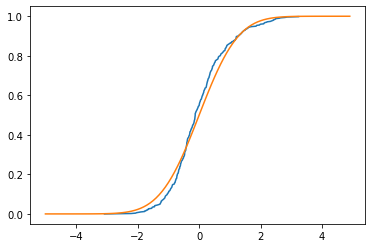

In [171]:
sorted_ = np.array(np.sort(u.T))[0]
yvals = np.arange(len(sorted_))/float(len(sorted_))
plt.plot(sorted_,yvals)

x = np.arange(-5, 5, 0.1)
y = stats.norm.cdf(x, 0, 1)
plt.plot(x, y)

{'mean': 3.581364595565021e-18, 'median': -0.12798704024175872, 'std': 0.9242354945259081, 'skewness': 0.5807154746142855, 'kurtosis': 0.7439668509114852}


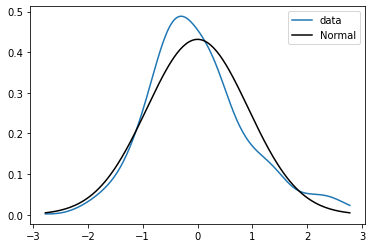

In [172]:
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print({'mean':mc,'median':np.median(close),'std':stdc,'skewness':stats.skew(close),'kurtosis':stats.kurtosis(close)})
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
statistics(np.array(u.T)[0])

In [138]:
axis0[2:]

['marketcap', 'bp']

In [134]:
axis0

['return', 'industry', 'marketcap', 'bp']

In [150]:
np.corrcoef([mv.to_numpy(),panel_data.loc[:,'bp'].to_numpy()])

array([[1.        , 0.33949859],
       [0.33949859, 1.        ]])

000501   -0.437204
600426    1.124580
600312   -0.025299
002233   -0.118591
000078   -1.096111
            ...   
600478   -1.477244
600017    2.069484
600874    0.360893
600138   -0.207994
600757   -0.253261
Name: bp, Length: 496, dtype: float64

In [152]:
data.keys()

dict_keys(['AdjFactor', 'BPS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

In [159]:
initiativebuy = pd.DataFrame(data['S_LI_INITIATIVEBUYRATE'],index=data['l2_ticker_names'],columns=pd.to_datetime(data['l2_dates'])).T
initiativesell = pd.DataFrame(data['S_LI_INITIATIVESELLRATE'],index=data['l2_ticker_names'],columns=pd.to_datetime(data['l2_dates'])).T

In [162]:
initiativebuy-initiativesell

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688687,688689,688696,688698,688699,688777,688788,688819,688981,T00018
1990-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,0.2654,-0.0976,NaN,-0.1612,-0.3396,0.0300,-0.2722,-0.2954,-0.1192,-0.1550,...,-0.2820,-0.0702,-0.1646,-0.0948,-0.0790,-0.1252,-0.0366,-0.1364,-0.1422,NaN
2021-04-22,-0.0464,0.0406,NaN,-0.2202,-0.2028,0.0236,-0.1624,-0.3072,-0.1262,0.1222,...,0.1808,0.0250,0.0288,-0.0206,-0.0126,-0.3758,-0.1264,-0.1104,0.1232,NaN
2021-04-23,0.1100,-0.2802,NaN,0.0740,-0.3482,-0.2282,-0.0618,-0.3472,0.0252,-0.2460,...,-0.3870,0.1352,0.0806,-0.1598,0.0912,-0.2538,-0.2802,0.0026,-0.0054,NaN
2021-04-26,-0.0008,-0.3096,NaN,-0.3038,0.2246,-0.1936,0.1828,-0.4908,-0.1030,-0.0256,...,0.1458,0.0660,0.1470,-0.1874,-0.2208,0.0630,-0.1156,-0.1236,-0.0592,NaN


In [201]:
data.keys()

dict_keys(['AdjFactor', 'BPS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

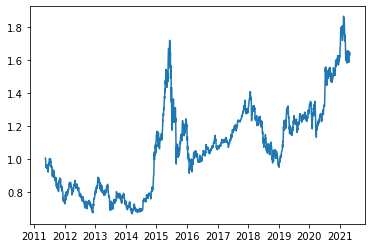

In [225]:
index_close = pd.DataFrame(data['index_ClosePrice'],index = data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T
index_return = np.log(index_close['000300']/(index_close['000300'].shift(1)))
plt.plot(np.exp(np.cumsum(index_return.iloc[5000:])))

,1990-12-19,1990-12-20,1990-12-21,1990-12-24,1990-12-25,1990-12-26,1990-12-27,1990-12-28,1990-12-31,1991-01-02,...,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-19,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-26
000001,100.00,104.390000,109.130000,114.550000,120.250000,125.270000,125.280000,126.450000,127.610000,128.840000,...,3396.470000,3416.721200,3398.987500,3426.617800,3477.548500,3472.942700,3472.929800,3465.113800,3474.166000,3441.165800
000001CNY01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3407.602400,3427.920800,3410.165300,3437.891200,3489.020100,3484.410100,3484.422500,3477.806600,3486.896100,3454.129900
000002,99.98,104.390000,109.130000,114.550000,120.250000,125.270000,125.280000,126.450000,127.610000,128.840000,...,3560.018200,3581.251300,3562.631700,3591.602700,3644.991500,3640.164700,3640.139600,3631.918800,3641.469100,3606.847900
000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,244.797700,245.965200,246.060300,247.611300,251.040000,250.672500,251.169200,251.829400,249.803400,248.808000
000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2995.640400,3022.048600,3014.267900,3039.704700,3095.774700,3096.278500,3092.728200,3089.743000,3108.757900,3085.398000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZCFI.WI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNCIF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNEIF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNFI.WI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
indx = pd.read_hdf('C:/Users/Administrator/Documents/members.hdf5')

In [3]:
import numpy as np
help(np.linalg.norm)

Help on function norm in module numpy.linalg:

norm(x, ord=None, axis=None, keepdims=False)
    Matrix or vector norm.
    
    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.
    
    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
        is None. If both `axis` and `ord` are None, the 2-norm of
        ``x.ravel`` will be returned.
    ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes``). inf means numpy's
        `inf` object. The default is None.
    axis : {None, int, 2-tuple of ints}, optional.
        If `axis` is an integer, it specifies the axis of `x` along which to
        compute the vector norms.  If `axis` is a 2-tuple, it specifies the
        axes that hold 2-D matrices, and the matrix norms of these